<a href="https://colab.research.google.com/github/xinyue-lily/Blogpost/blob/main/blogpost5-20220226.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import utils 

construct three datasets

In [2]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                           shuffle=True,
                           batch_size=BATCH_SIZE,
                           image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                           shuffle=True,
                           batch_size=BATCH_SIZE,
                           image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Read the data rapidly

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

 Visualiazation of images

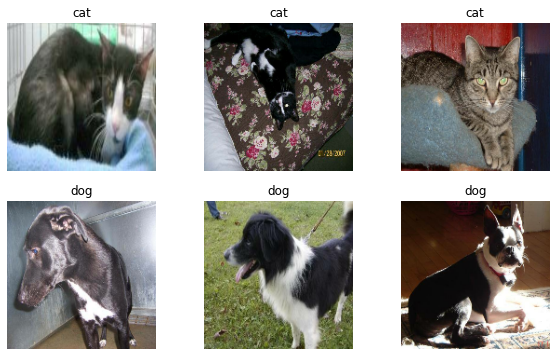

In [ ]:
def plot_images():
  cat = 0
  dog = 0
  plt.figure(figsize=(10, 6))
  for images, labels in train_dataset.take(1):
    for i in range(32):
      if labels[i].numpy().astype("uint8")==0 and cat < 3:
        cat = cat + 1
        ax = plt.subplot(2, 3, cat)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("cat")
      elif labels[i].numpy().astype("uint8")==1 and dog < 3:
        dog = dog + 1
        ax = plt.subplot(2, 3, dog+3)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("dog")
      plt.axis("off")
      if cat >= 3 and dog >= 3:
        break

plot_images()
    

Check Label Frequencies

In [ ]:
labels_iterator= train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()
sum(labels_iterator)

1000

First Model-Model1

In [ ]:
from tensorflow.keras import datasets, layers, models
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1)
])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 82944)             0

In [ ]:
model1.compile(optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

history = model1.fit(train_dataset, 
      epochs=20, 
      validation_data=(validation_dataset)) 

Epoch 1/20
63/63 [==============================] - 15s 84ms/step - loss: 14.9680 - accuracy: 0.5020 - val_loss: 1.3192 - val_accuracy: 0.5767
Epoch 2/20
63/63 [==============================] - 5s 78ms/step - loss: 1.4859 - accuracy: 0.6220 - val_loss: 0.7335 - val_accuracy: 0.5359
Epoch 3/20
63/63 [==============================] - 5s 76ms/step - loss: 1.1852 - accuracy: 0.7100 - val_loss: 1.6542 - val_accuracy: 0.5520
Epoch 4/20
63/63 [==============================] - 5s 76ms/step - loss: 1.1305 - accuracy: 0.7535 - val_loss: 1.3431 - val_accuracy: 0.5891
Epoch 5/20
63/63 [==============================] - 5s 77ms/step - loss: 0.9074 - accuracy: 0.7830 - val_loss: 1.4732 - val_accuracy: 0.5953
Epoch 6/20
63/63 [==============================] - 5s 79ms/step - loss: 0.7497 - accuracy: 0.8470 - val_loss: 1.7030 - val_accuracy: 0.6262
Epoch 7/20
63/63 [==============================] - 5s 77ms/step - loss: 0.6086 - accuracy: 0.8820 - val_loss: 1.6452 - val_accuracy: 0.6213
Epoch 8/20


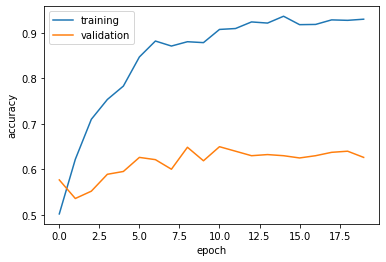

In [ ]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

Model with Data Augmentation-Model2

In [4]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical")
  #tf.keras.layers.RandomFlip("horizontal")
])

data_rotation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.2),
])

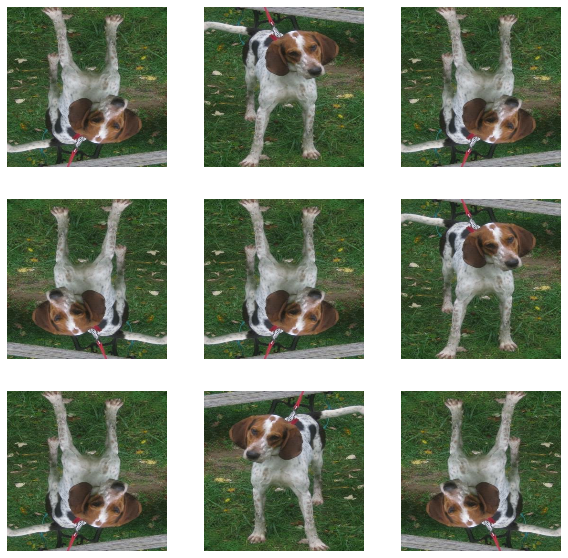

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/ 255)
    plt.axis('off')
  

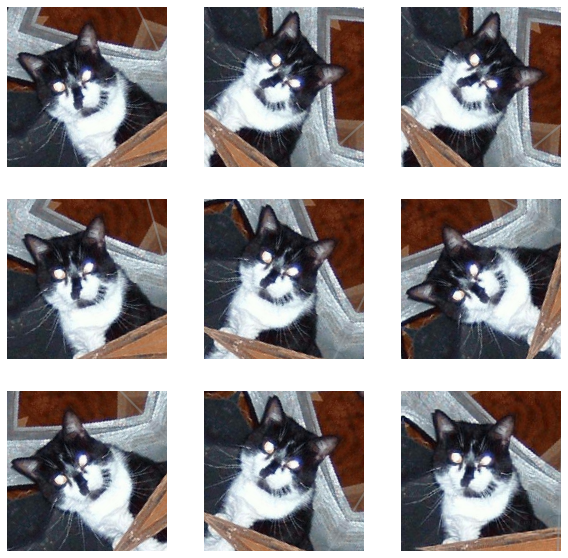

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rotated_image = data_rotation(tf.expand_dims(first_image, 0))
    plt.imshow(rotated_image[0]/ 255)
    plt.axis('off')

Model2

In [5]:
model2 = models.Sequential([
    data_augmentation,
    data_rotation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.1)
])

In [6]:
model2.compile(optimizer='adam',
       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
       metrics=['accuracy'])

history = model2.fit(train_dataset, 
       epochs=20, 
       validation_data=(validation_dataset))

Epoch 1/20
63/63 [==============================] - 61s 879ms/step - loss: 24.7791 - accuracy: 0.4025 - val_loss: 0.7663 - val_accuracy: 0.5012
Epoch 2/20
63/63 [==============================] - 56s 880ms/step - loss: 0.7093 - accuracy: 0.5510 - val_loss: 0.7654 - val_accuracy: 0.5198
Epoch 3/20
63/63 [==============================] - 55s 870ms/step - loss: 0.7250 - accuracy: 0.5310 - val_loss: 0.6852 - val_accuracy: 0.5644
Epoch 4/20
63/63 [==============================] - 55s 867ms/step - loss: 0.7036 - accuracy: 0.5470 - val_loss: 0.6981 - val_accuracy: 0.5755
Epoch 5/20
63/63 [==============================] - 55s 865ms/step - loss: 0.7163 - accuracy: 0.5390 - val_loss: 0.6948 - val_accuracy: 0.5532
Epoch 6/20
63/63 [==============================] - 55s 864ms/step - loss: 0.6944 - accuracy: 0.5515 - val_loss: 0.7270 - val_accuracy: 0.5483
Epoch 7/20
63/63 [==============================] - 55s 866ms/step - loss: 0.6996 - accuracy: 0.5470 - val_loss: 0.7354 - val_accuracy: 0.553

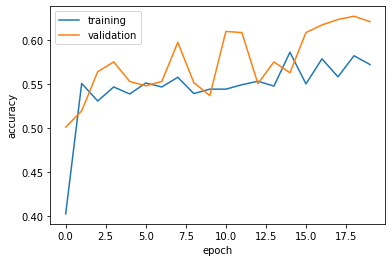

In [7]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

Data Prerocessing-Model3

Preporcessor

In [ ]:
i = tf.keras.Input(shape=(160,160,3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs=[i],outputs=[x])

Model3

In [ ]:
from tensorflow.keras import datasets, layers, models
model3 = models.Sequential([
    preprocessor,
    data_augmentation,
    data_rotation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu')
])

In [ ]:
model3.compile(optimizer='adam',
       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
       metrics=['accuracy'])

history = model3.fit(train_dataset, 
       epochs=20, 
       validation_data=(validation_dataset)) 

Epoch 1/20
63/63 [==============================] - 56s 867ms/step - loss: 1.0862 - accuracy: 0.5055 - val_loss: 0.6877 - val_accuracy: 0.5173
Epoch 2/20
63/63 [==============================] - 54s 851ms/step - loss: 0.6886 - accuracy: 0.5505 - val_loss: 0.6636 - val_accuracy: 0.5891
Epoch 3/20
63/63 [==============================] - 54s 848ms/step - loss: 0.6659 - accuracy: 0.6000 - val_loss: 0.6382 - val_accuracy: 0.6052
Epoch 4/20
63/63 [==============================] - 54s 847ms/step - loss: 0.6476 - accuracy: 0.6115 - val_loss: 0.6162 - val_accuracy: 0.6498
Epoch 5/20
63/63 [==============================] - 54s 850ms/step - loss: 0.6258 - accuracy: 0.6440 - val_loss: 0.6488 - val_accuracy: 0.6027
Epoch 6/20
63/63 [==============================] - 58s 925ms/step - loss: 0.6208 - accuracy: 0.6550 - val_loss: 0.5785 - val_accuracy: 0.6894
Epoch 7/20
63/63 [==============================] - 55s 862ms/step - loss: 0.5892 - accuracy: 0.6825 - val_loss: 0.5774 - val_accuracy: 0.7116

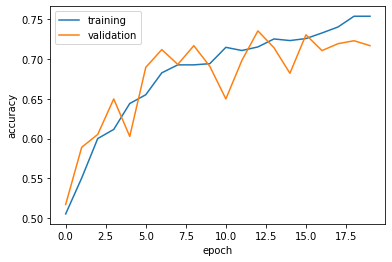

In [ ]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

Transfer Learning

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                        include_top=False,
                        weights='imagenet')
base_model.trainable = False
i = tf.keras.Input(shape = IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs=[i], outputs = [x])

9420800/9406464 [==============================] - 0s 0us/step


Model4

In [ ]:
model4 = models.Sequential([
    preprocessor,
    data_augmentation,
    data_rotation,
    base_model_layer,
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.1),
    layers.Dense(1)
])

In [ ]:
base_learning_rate = 0.0001
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model5.fit(train_dataset, 
           epochs=20, 
           validation_data = (validation_dataset)) 

Epoch 1/20
63/63 [==============================] - 11s 114ms/step - loss: 1.1790 - accuracy: 0.6260 - val_loss: 0.5757 - val_accuracy: 0.7624
Epoch 2/20
63/63 [==============================] - 6s 84ms/step - loss: 0.6274 - accuracy: 0.7520 - val_loss: 0.3476 - val_accuracy: 0.8540
Epoch 3/20
63/63 [==============================] - 6s 86ms/step - loss: 0.4338 - accuracy: 0.8190 - val_loss: 0.2766 - val_accuracy: 0.8849
Epoch 4/20
63/63 [==============================] - 6s 84ms/step - loss: 0.3598 - accuracy: 0.8430 - val_loss: 0.2128 - val_accuracy: 0.9097
Epoch 5/20
63/63 [==============================] - 6s 84ms/step - loss: 0.3143 - accuracy: 0.8700 - val_loss: 0.1897 - val_accuracy: 0.9245
Epoch 6/20
63/63 [==============================] - 6s 84ms/step - loss: 0.2880 - accuracy: 0.8855 - val_loss: 0.1594 - val_accuracy: 0.9369
Epoch 7/20
63/63 [==============================] - 6s 84ms/step - loss: 0.2399 - accuracy: 0.9090 - val_loss: 0.1446 - val_accuracy: 0.9480
Epoch 8/20


The learning curve of training and verifying accuracy

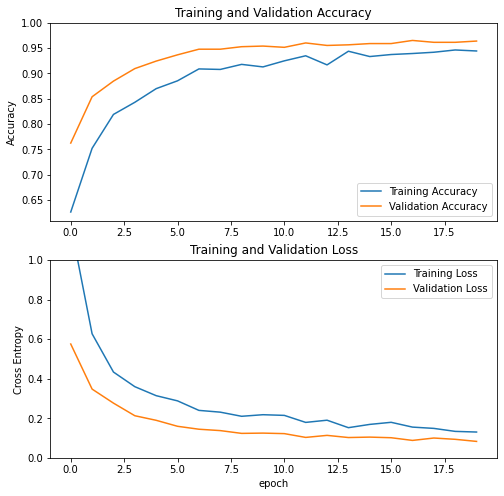

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Test accuracy

In [ ]:
initial_epochs = 10
loss,accuray = model4.evaluate(test_dataset)
accuray

6/6 [==============================] - 1s 64ms/step - loss: 0.0541 - accuracy: 0.9740


[0.05411681905388832, 0.9739583134651184]